In [1]:
import os
import pickle
import numpy as np
from music21 import note, chord, corpus, converter, stream, instrument
import glob
from tensorflow.keras.utils import to_categorical
from tqdm.notebook import tqdm


In [2]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import LSTM, Input, Dropout, Dense, Activation, Embedding, Concatenate, Reshape
from tensorflow.keras.layers import Flatten, RepeatVector, Permute, TimeDistributed
from tensorflow.keras.layers import Multiply, Lambda, Softmax
import tensorflow.keras.backend as K 
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop

Git data


In [3]:
data_dir = 'C:/Users/VS/Desktop/musicVS/romance/'

# list of files
midi_list = os.listdir(data_dir)

# Load and make list of stream objects
original_scores = []
for midi in tqdm(midi_list):
    score = converter.parse(os.path.join(data_dir,midi))
    original_scores.append(score)

  0%|          | 0/51 [00:00<?, ?it/s]

Merge Notes to Chords

In [4]:
# Merge notes into chords
original_scores = [midi.chordify() for midi in tqdm(original_scores)]

  0%|          | 0/51 [00:00<?, ?it/s]

In [5]:
list=[original_scores]
original="list.pkl"
open_file=open(original,"wb")
pickle.dump(list,open_file)
open_file.close()

open_file = open(original, "rb")
loaded_list = pickle.load(open_file)
open_file.close()

print(loaded_list)

[[<music21.stream.Part 2644844767840>, <music21.stream.Part 2645165733104>, <music21.stream.Part 2645175700112>, <music21.stream.Part 2645187445136>, <music21.stream.Part 2645200852256>, <music21.stream.Part 2645212204816>, <music21.stream.Part 2645229065696>, <music21.stream.Part 2645231249728>, <music21.stream.Part 2645249221920>, <music21.stream.Part 2645264820640>, <music21.stream.Part 2645281529920>, <music21.stream.Part 2645295403408>, <music21.stream.Part 2645305638864>, <music21.stream.Part 2645325978928>, <music21.stream.Part 2645341680016>, <music21.stream.Part 2645360629936>, <music21.stream.Part 2645373896160>, <music21.stream.Part 2645393279680>, <music21.stream.Part 2645402617456>, <music21.stream.Part 2645416075712>, <music21.stream.Part 2645424415552>, <music21.stream.Part 2645439880496>, <music21.stream.Part 2645459172080>, <music21.stream.Part 2645475655296>, <music21.stream.Part 2645490286544>, <music21.stream.Part 2645513547344>, <music21.stream.Part 2645537893872>,

Get Notes and Duration Information

In [6]:
# Define empty lists of lists
original_chords = [[] for _ in original_scores]
original_durations = [[] for _ in original_scores]
original_keys = []

# Extract notes, chords, durations, and keys
for i, midi in tqdm(enumerate(original_scores)):
    original_keys.append(str(midi.analyze('key')))
    for element in midi:
        if isinstance(element, note.Note):
            original_chords[i].append(element.pitch)
            original_durations[i].append(element.duration.quarterLength)
        elif isinstance(element, chord.Chord):
            original_chords[i].append('.'.join(str(n) for n in element.pitches))
            original_durations[i].append(element.duration.quarterLength)

0it [00:00, ?it/s]

Reduce Dimensionality

In [7]:
# Create list of chords and durations from songs in C major
major_chords = [c for (c, k) in tqdm(zip(original_chords, original_keys)) if (k == 'C major')]
major_durations = [c for (c, k) in tqdm(zip(original_durations, original_keys)) if (k == 'C major')]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Prepare Duration and Note Mappings

In [9]:
def get_distinct(elements):
    # Get all pitch names
    element_names = sorted(set(elements))
    n_elements = len(element_names)
    return (element_names, n_elements)

def create_lookups(element_names):
    # create dictionary to map notes and durations to integers
    element_to_int = dict((element, number) for number, element in enumerate(element_names))
    int_to_element = dict((number, element) for number, element in enumerate(element_names))

    return (element_to_int, int_to_element)

In [10]:
store_folder = 'parsed_data'
os.mkdir(store_folder)

FileExistsError: [WinError 183] Cannot create a file when that file already exists: 'parsed_data'

In [11]:
# get the distinct sets of notes and durations
note_names, n_notes = get_distinct([n for chord in major_chords for n in chord])
duration_names, n_durations = get_distinct([d for dur in major_durations for d in dur])
distincts = [note_names, n_notes, duration_names, n_durations]

with open(os.path.join(store_folder, 'distincts'), 'wb') as f:
    pickle.dump(distincts, f)

In [12]:
# make the lookup dictionaries for notes and dictionaries and save
note_to_int, int_to_note = create_lookups(note_names)
duration_to_int, int_to_duration = create_lookups(duration_names)
lookups = [note_to_int, int_to_note, duration_to_int, int_to_duration]

with open(os.path.join(store_folder, 'lookups'), 'wb') as f:
    pickle.dump(lookups, f)

In [13]:
print("Unique Notes={} and Duration values={}".format(n_notes,n_durations))

Unique Notes=3950 and Duration values=36


Prepare Sequences

In [14]:
# Set sequence length
sequence_length = 32

# Define empty array for train data
train_chords = []
train_durations = []
target_chords = []
target_durations = []

# Construct train and target sequences for chords and durations
for s in range(len(major_chords)):
    chord_list = [note_to_int[c] for c in major_chords[s]]
    duration_list = [duration_to_int[d] for d in major_durations[s]]
    for i in range(len(chord_list) - sequence_length):
        train_chords.append(chord_list[i:i+sequence_length])
        train_durations.append(duration_list[i:i+sequence_length])
        target_chords.append(chord_list[i+1])
        target_durations.append(duration_list[i+1])

In [15]:
train_chords = np.array(train_chords)
train_durations = np.array(train_durations)
target_chords = np.array(target_chords)
target_durations = np.array(target_durations)

Prepare Model

In [16]:
def create_network(n_notes, n_durations, embed_size = 100, rnn_units = 256):
    """ create the structure of the neural network """

    notes_in = Input(shape = (None,))
    durations_in = Input(shape = (None,))

    x1 = Embedding(n_notes, embed_size)(notes_in)
    x2 = Embedding(n_durations, embed_size)(durations_in) 

    x = Concatenate()([x1,x2])

    x = LSTM(rnn_units, return_sequences=True)(x)

    x = LSTM(rnn_units, return_sequences=True)(x)

    # attention
    e = Dense(1, activation='tanh')(x)
    e = Reshape([-1])(e)
    alpha = Activation('softmax')(e)

    alpha_repeated = Permute([2, 1])(RepeatVector(rnn_units)(alpha))

    c = Multiply()([x, alpha_repeated])
    c = Lambda(lambda xin: K.sum(xin, axis=1), output_shape=(rnn_units,))(c)
    
                                    
    notes_out = Dense(n_notes, activation = 'softmax', name = 'pitch')(c)
    durations_out = Dense(n_durations, activation = 'softmax', name = 'duration')(c)
   
    model = Model([notes_in, durations_in], [notes_out, durations_out])
    model.compile(loss=['sparse_categorical_crossentropy', 
                        'sparse_categorical_crossentropy'], optimizer=RMSprop(lr = 0.001))

    return model

In [17]:
embed_size = 128
rnn_units = 128

In [18]:
model = create_network(n_notes, n_durations, embed_size, rnn_units)

c:\Users\VS\AppData\Local\Programs\Python\Python38\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [19]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 128)    505600      input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 128)    4608        input_2[0][0]                    
______________________________________________________________________________________________

Train the Model

In [20]:
os.mkdir('outputs')
os.mkdir('outputs/output')
os.mkdir('outputs/weights')

FileExistsError: [WinError 183] Cannot create a file when that file already exists: 'outputs'

In [21]:
output_folder = 'outputs'
weights_folder = os.path.join(output_folder, 'weights')


checkpoint = ModelCheckpoint(
    os.path.join(weights_folder, "weights.h5"),
    monitor='loss',
    verbose=0,
    save_best_only=True,
    mode='min'
)

epoch_checkpoint = ModelCheckpoint(
    os.path.join(weights_folder, "weights-{epoch:02d}-{loss:.4f}.h5"),
    monitor='loss',
    verbose=0,
    save_best_only=True,
    mode='min'
)

early_stopping = EarlyStopping(
    monitor='loss'
    , restore_best_weights=True
    , patience = 5
)


callbacks_list = [
    checkpoint
    , epoch_checkpoint
    , early_stopping
 ]

model.save_weights(os.path.join(weights_folder, "weights.h5"))

In [33]:
history = model.fit([train_chords, train_durations], 
                    [target_chords, target_durations]
                    , epochs=80, batch_size=128
                    , callbacks=callbacks_list
                    , shuffle=True
                  )

Epoch 1/80
70/70 [==============================] - 29s 281ms/step - loss: 10.0694 - pitch_loss: 8.1698 - duration_loss: 1.8996


c:\Users\VS\AppData\Local\Programs\Python\Python38\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/80
70/70 [==============================] - 19s 273ms/step - loss: 9.5002 - pitch_loss: 7.8324 - duration_loss: 1.6679
Epoch 3/80
70/70 [==============================] - 19s 270ms/step - loss: 9.1289 - pitch_loss: 7.6115 - duration_loss: 1.5173
Epoch 4/80
70/70 [==============================] - 19s 274ms/step - loss: 8.7443 - pitch_loss: 7.4327 - duration_loss: 1.3116
Epoch 5/80
70/70 [==============================] - 19s 277ms/step - loss: 8.4558 - pitch_loss: 7.2941 - duration_loss: 1.1617
Epoch 6/80
70/70 [==============================] - 19s 277ms/step - loss: 8.1436 - pitch_loss: 7.1818 - duration_loss: 0.9618
Epoch 7/80
70/70 [==============================] - 20s 288ms/step - loss: 7.8271 - pitch_loss: 7.0995 - duration_loss: 0.7275
Epoch 8/80
70/70 [==============================] - 19s 278ms/step - loss: 7.5769 - pitch_loss: 6.9997 - duration_loss: 0.5773
Epoch 9/80
70/70 [==============================] - 20s 281ms/step - loss: 7.3925 - pitch_loss: 6.8924 - durati

In [34]:
from matplotlib import pyplot as plt

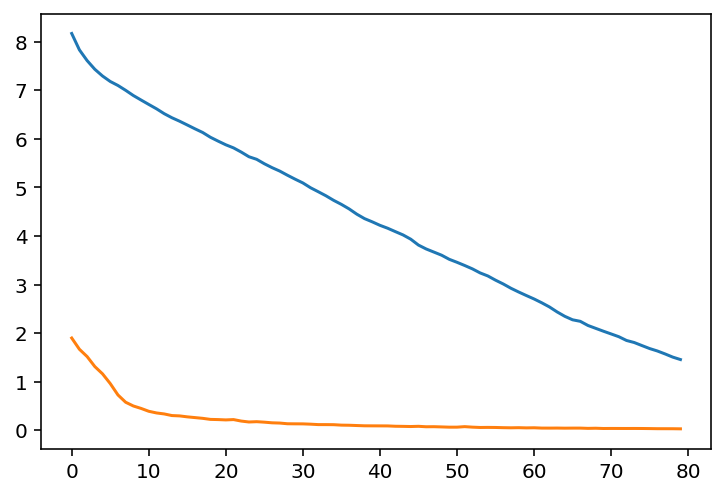

In [35]:
# get plots
plt.plot(history.history['pitch_loss'])
plt.plot(history.history['duration_loss'])
plt.show()

Generate Music

In [22]:
def sample_with_temp(preds, temperature):

    if temperature == 0:
        return np.argmax(preds)
    else:
        preds = np.log(preds) / temperature
        exp_preds = np.exp(preds)
        preds = exp_preds / np.sum(exp_preds)
        return np.random.choice(len(preds), p=preds)

In [23]:
# chord and duration sequences
initial_chords = np.expand_dims(train_chords[0,:].copy(), 0)
initial_durations = np.expand_dims(train_durations[0,:].copy(), 0)

In [24]:
initial_chords

array([[3881, 1328, 1347, 3937, 3937, 2232, 2155, 2153, 2154, 2154, 1319,
        3904, 1319, 1319, 1315, 1315, 1315, 3904, 3904, 3918, 3918, 2849,
        2850, 2795, 2758, 2753, 2753, 2717, 2806, 2805, 2811, 2233]])

In [25]:
initial_durations

array([[ 8,  8,  2,  5,  0,  5,  0,  3,  0,  2, 11,  3,  4,  1,  0,  2,
         0,  3,  0,  5,  0,  2,  1,  2,  3,  1, 24,  5,  0,  1,  1,  0]])

In [26]:
# Function to predict chords and durations
def predict_chords(chord_sequence, duration_sequence,model,temperature=1.0):
    predicted_chords, predicted_durations = model.predict([chord_sequence, duration_sequence])
    return sample_with_temp(predicted_chords[0],temperature), sample_with_temp(predicted_durations[0],temperature)

In [27]:
# Define empty lists for generated chords and durations
new_chords, new_durations = [], []

# Generate chords and durations using 50 rounds of prediction
for j in range(50):
    new_chord, new_duration = predict_chords(initial_chords, 
                                             initial_durations,
                                             model,
                                             temperature=0.8)
    new_chords.append(new_chord)
    new_durations.append(new_duration)
    initial_chords[0][:-1] = initial_chords[0][1:]
    initial_chords[0][-1] = new_chord
    initial_durations[0][:-1] = initial_durations[0][1:]
    initial_durations[0][-1] = new_duration

In [28]:
# Create stream object and add guitar as instrument
generated_stream = stream.Stream()
generated_stream.append(instrument.Piano())

# Add notes and durations to stream
for j in range(len(new_chords)):
    try:
        generated_stream.append(note.Note(int_to_note[new_chords[j]].replace('.', ' '), 
                                          quarterType = int_to_duration[new_durations[j]]))
    except:
        generated_stream.append(chord.Chord(int_to_note[new_chords[j]].replace('.', ' '), 
                                            quarterType = int_to_duration[new_durations[j]]))

# Export as MIDI file
generated_stream.write('midi', fp='lstm_50epoch9.mid')

'lstm_50epoch9.mid'

In [29]:
import tensorflow as tf
print(tf.version.VERSION)

2.5.0


In [30]:
import keras
print(keras.version)

AttributeError: module 'tensorflow.compat.v2.__internal__' has no attribute 'register_clear_session_function'

In [2]:
from keras.models import load_model
# load the model
#here is name of model $$$$$$
model = load_model('C:/Users/VS/Desktop/musicVS/outputs/weights/weights.h5')

AttributeError: module 'tensorflow.compat.v2.__internal__' has no attribute 'register_clear_session_function'